In [119]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['LANGCHAIN_API_KEY']=os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_ENDPOINT']=os.getenv('LANGCHAIN_ENDPOINT')
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['LANGCHAIN_TRACING_V2']='true'
os.environ['LANGCHAIN_PROJECT']=os.getenv('LANGCHAIN_PROJECT')
os.environ['LANGCHAIN_HUB_API_URL']=os.getenv('LANGCHAIN_HUB_API_URL')
os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')

In [120]:
from langchain_core.messages import BaseMessage,HumanMessage,AIMessage,SystemMessage
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from typing import List,TypedDict,Optional,Annotated
from langchain.prompts import ChatPromptTemplate,MessagesPlaceholder

In [121]:
class PoemState(TypedDict):
    topic:str
    poem:str
    critic:str=None

In [122]:
generate_prompt=ChatPromptTemplate.from_messages(
    [
        SystemMessage("You are a turkish style romantic poet." \
        "compose coherent poems related to the provided topic." \
        "If you are provided a critic then regenerate the poem in a better way than before." \
        "return only the poem and nothing else."),
        MessagesPlaceholder("topic"),
        MessagesPlaceholder("poem",optional=True),
        MessagesPlaceholder('critic',optional=True)
    ]
)

reflect_prompt=ChatPromptTemplate.from_messages([
    SystemMessage("you are an experienced poem critic." \
    "very sharply review the provided poem in terns of pronunciation and coherence and give it a 'PASS' or 'FAIL'." \
    "Your responses must be one of the following types:\n\n" \
    "example 1: PASS (JUST PASS NOTHING ELSE,PLEASE🥺)" \
    "example 2: FAIL. <Everything wrong with the poem>" \
    "" \
    "return only the critic and nothing else."),
    MessagesPlaceholder('topic'),
    MessagesPlaceholder("poem")
])

In [123]:
llm=ChatGroq(model="llama-3.1-8b-instant")

In [124]:
generate=generate_prompt | llm

reflect=reflect_prompt | llm

In [125]:
text=""
for e in generate.stream({'topic':[HumanMessage("Lone wolf")]}):
    text+=e.content
    print(e.content,end="")

Moonlit night, a lone wolf roams 
Through shadows cast, with heart of stones 
His howls echo, a haunting sigh 
As he wanders, with a lonely eye 

His fur a grey, like the night's own hue 
Unbound and free, with a spirit anew 
He runs with the wind, wild and untamed 
A solitary soul, with a heart that's framed 

In the darkness, he finds his peace 
A world of solace, where love won't cease 
For in his loneliness, he's found a friend 
A bond with the night, that will never end 

His heart beats strong, like a drum in the night 
A rhythm that echoes, a solitary delight 
For in his freedom, he's found a home 
A place where he belongs, where he's never alone.

In [126]:
for e in reflect.stream({"topic":[HumanMessage("lone wolf")],'poem':[HumanMessage(content=text)]}):
    print(e.content,end="")

FAIL. 

The poem lacks structure and rhyme scheme consistency, making it difficult to follow and understand. The language is somewhat clichéd, with overused metaphors such as "heart of stones" and "spirit anew." The tone is also somewhat inconsistent, veering between melancholy and celebratory. The second and fourth lines of many stanzas are repetitive and do not add much to the poem's message. The poem's themes of loneliness and freedom are not fully explored, and the language and imagery do not provide a rich enough understanding of the subject.

In [127]:
def generate_node(state:PoemState):
    if state['critic']:
        return {
            "topic":state['topic'],
            'poem':generate.invoke({
                'topic':[HumanMessage(state['topic'])],
                "poem":[HumanMessage(state['poem']).content],
                'critic':[HumanMessage(state['critic'])]
                }).content,
            'critic':None
        }
    else:
        return {
            "topic":state['topic'],
            'poem':generate.invoke({'topic':[HumanMessage(state['topic'])]}).content,
            'critic':state['critic']
        }
    
reflect_count=5
def reflect_node(state:PoemState):
    global reflect_count
    if reflect_count == 0:
        return {
        "topic":state['topic'],
        "poem":state['poem'],
        'critic':"PASS"
    }
    reflect_count-=1
    print("reflect_count=", reflect_count)
    return {
        "topic":state['topic'],
        "poem":state['poem'],
        'critic':reflect.invoke({
            'topic':[HumanMessage(state['topic'])],
            'poem':[HumanMessage(state['poem']).content]
        }).content
    }

In [128]:
def should_continue(state:PoemState):
    crit = state['critic']
    if crit[:4]=='PASS':
        return END
    else:
        return "generate"

In [129]:
graph=StateGraph(PoemState)

graph.add_node("generate",generate_node)
graph.add_node("reflect",reflect_node)

graph.set_entry_point('generate')
graph.add_edge("generate","reflect")
# graph.add_edge('reflect','generate')

graph.add_conditional_edges(
    'reflect',should_continue,{
        'generate':'generate',
        END:END,
    }
)

w=graph.compile()

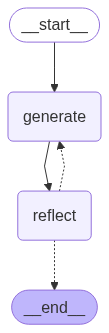

In [130]:
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        w.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [131]:
state={
    "topic":"The strangest creature on earth.",
    'poem':None,
    'critic':None
}

In [132]:
for e in w.stream(state):
    print(e)

{'generate': {'topic': 'The strangest creature on earth.', 'poem': "In twilight's hush, where shadows dance and play,\nA creature stirs, in mystic, secret way,\nWith eyes that gleam like stars in midnight's sway,\nIt moves unseen, in a mysterious bay.\n\nIts form is twisted, a labyrinthine design,\nA puzzle of limbs, in an otherworldly shrine,\nIt defies explanation, a riddle unaligned,\nA marvel of nature, in an enigmatic line.\n\nWith skin that shimmers like the moon's pale light,\nIt glides, a phantom, through the darkest night,\nIts presence whispers secrets, in a language unknown,\nA mystery that haunts, like a ghostly moan.\n\nIn ancient tales, it's spoken of, in hushed, reverent tone,\nA creature of wonder, in a realm beyond our own,\nA symbol of the unknown, a whisper of the divine,\nA stranger in our world, in a mystic, otherworldly shrine.", 'critic': None}}
reflect_count= 4
{'reflect': {'topic': 'The strangest creature on earth.', 'poem': "In twilight's hush, where shadows d